In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv("fake_job_postings.csv")
print(df.head(5))
print(len(df))



   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

Some textual data have missing values, so going to fill those missing values with an empty space. 

We don't want to completely delete the rows with missing values because that could be the defining feature in terms of if a job posting if fradulent or not. 

A missing value should be a valid value for all the features. As a result, we're just filling it with a space. 

In [ ]:
df.fillna(' ', inplace=True)


Concatenating all textual data as well as downsampling majority class. 

We have to downsample the non-fradulent instances (or upsample fradulent instances. The only issue might be that data is duplicated) so that our model does not become biased. 

We're also combining all of the textual data into one so that we can feed this text into our doc2vec model. 

In [ ]:
df0 = df[df['fraudulent']==0]
df0 = df0.sample(1000)

df2 = df[df['fraudulent']==1]

balanced = pd.concat([df0,df2],axis=0)
balanced["combined_text"] = balanced["title"] + " " + balanced["description"] + " " + balanced["benefits"] + " " + balanced["requirements"] + " " + balanced["salary_range"] 

train_df = balanced

print(train_df.head(5))
print()
print(f"Num Missing Values = {train_df.isnull().sum() + train_df.isna().sum()}")
print()
print(train_df.describe())

       job_id                                        title  \
209       210                  Customer Service Associate    
7885     7886                      Senior Benefits Analyst   
15352   15353    Submit Your Resume for Upcoming Positions   
4897     4898      Customer Service Associate - Part Time    
15543   15544  Senior Full Stack Developer (Ruby on Rails)   

                     location      department salary_range  \
209    US, ME, South Portland                                
7885         US, CA, Redlands              HR                
15352    US, CA, Los Angeles   Nonprofit Only                
4897        US, NC, Charlotte                                
15543        US, NY, Brooklyn     Engineering                

                                         company_profile  \
209    Novitex Enterprise Solutions, formerly Pitney ...   
7885   Our passion for improving quality of life thro...   
15352  Envision Consulting conducts retained searches...   
4897   Novitex

Going to use doc2vec to transform textual data into a vector of numerical values. Not doing in any preprocessing such as removing stop words.

In [ ]:
docs = [text.split() for text in train_df["combined_text"]]#list of lists of words
tagged_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
doc2vec_model = Doc2Vec(tagged_docs) # can have optional vector_size to set dimensionality

Finding the columns that can pass as categorical data.

{'telecommuting': 2, 'has_company_logo': 2, 'has_questions': 2, 'employment_type': 6, 'required_experience': 8, 'required_education': 12}
TRAINING DF SIZE 1866


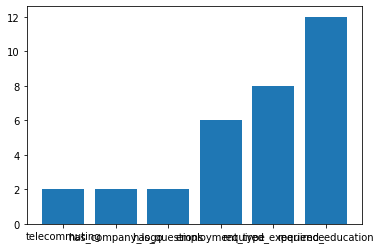

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'combined_text', 'telecommuting_0', 'telecommuting_1',
       'has_company_logo_0', 'has_company_logo_1', 'has_questions_0',
       'has_questions_1', 'employment_type_ ', 'employment_type_Contract',
       'employment_type_Full-time', 'employment_type_Other',
       'employment_type_Part-time', 'employment_type_Temporary',
       'required_experience_ ', 'required_experience_Associate',
       'required_experience_Director', 'required_experience_Entry level',
       'required_experience_Executive', 'required_experience_Internship',
       'required_experience_Mid-Senior level',
       'required_experience_Not Applicable', 'required_education_ ',
       'required_education_Asso

In [ ]:
cleaned_train_df = train_df.copy()

NUM_UNIQUE = 20
categorical = {}

for col in cleaned_train_df.columns:
  if col != "combined_text" and col != 'fraudulent':
    num_unique = cleaned_train_df[col].nunique()
    if num_unique < NUM_UNIQUE:
      categorical[col] = num_unique

print(categorical)
plt.bar(categorical.keys(), categorical.values(), width = 1.2)
print(f"TRAINING DF SIZE {len(cleaned_train_df)}")

plt.show()

encoded_categorical_col_values = {}

for col in categorical:
  encoded_categorical = pd.get_dummies(cleaned_train_df[col], prefix=col)
  encoded_categorical_col_values[col] = encoded_categorical.columns
  for encoded_col in encoded_categorical.columns:
    cleaned_train_df[encoded_col] = encoded_categorical[encoded_col]
  

print(cleaned_train_df.columns)
print(len(cleaned_train_df))



Converting all the textual data into vectors using the model

Appending the one-hot encoded categorical values to the doc embeddings.

In [ ]:
#X = [doc2vec_model.infer_vector(doc.split()) for doc in cleaned_train_df["combined_text"]]
X = []
# append encoded_categorical to X
for _, row in cleaned_train_df.iterrows():
  feature_vector = doc2vec_model.infer_vector(row["combined_text"].split())
  for col in categorical:
    encoded_vec = []
    for encoded_col in encoded_categorical_col_values[col]:
      encoded_vec.append(row[encoded_col])
    feature_vector = np.append(feature_vector, encoded_vec)
    
  X.append(feature_vector)

Y = [y for y in train_df["fraudulent"]]

Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)


(1492, 132)


In [ ]:
def build_model(input_shape, n_hidden, n_neurons_hidden, n_neurons_output, learning_rate):

    #-->add your Pyhton code here

    #Creating the Neural Network using the Sequential API
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))                                #input layer

    #iterate over the number of hidden layers to create the hidden layers:
    for i in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons_hidden, activation="relu"))                   #hidden layer with ReLU activation function

    #output layer
    model.add(keras.layers.Dense(n_neurons_output, activation="softmax"))                #output layer with one neural for each class and the softmax activation function since the classes are exclusive

    #defining the learning rate
    opt = keras.optimizers.SGD(learning_rate)

    #Compiling the Model specifying the loss function and the optimizer to use.
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
classifier = build_model((132,),20, 100, 2, .2)

classifier.fit(x_train, y_train)

result = classifier.evaluate(x_test, y_test)
print(f"Toy Neural Network Accuracy: {result[1]}")


12/12 [==============================] - 0s 2ms/step - loss: 0.6911 - accuracy: 0.5348
Toy Neural Network Accuracy: 0.5347593426704407


Going to try with Random Forests to see if I get better results.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=20) #this is the number of decision trees that will be generated by Random Forest. The sample of the ensemble method used before

#Fit Random Forest to the training data
clf.fit(x_train, y_train)

pred_true = 0
pred_total = 0
   
for x, y in zip(x_test, y_test):
   pred_class = clf.predict([x])[0]
   if pred_class == y: pred_true += 1
   pred_total += 1
#printing Random Forest accuracy here
print("Random Forest accuracy: " + str(pred_true / pred_total))

Random Forest accuracy: 0.8342245989304813


Going to try to see if there is an improvement if we reduce the dimensions using PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

num_components = 0
running_var = 0
for var in pca.explained_variance_ratio_:
  num_components += 1
  running_var += var
  if running_var >= .9:
    break

print(f"NUM COMPONENTS NEEDED TO GET AROUND 90% VARIANCE {num_components}")

NUM COMPONENTS NEEDED TO GET AROUND 90% VARIANCE 19


Refit PCA with 19 components

In [ ]:
pca = PCA(n_components=num_components)
transform_x = pca.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(transform_x, Y, test_size=0.20, stratify=Y)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)


(1492, 19)


In [ ]:
classifier = build_model((num_components,),20, 100, 2, .2)

classifier.fit(x_train, y_train)

result = classifier.evaluate(x_test, y_test)
print(f"Toy Neural Network Accuracy: {result[1]}")

12/12 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5348
Toy Neural Network Accuracy: 0.5347593426704407


In [ ]:
clf=RandomForestClassifier(n_estimators=20) #this is the number of decision trees that will be generated by Random Forest. The sample of the ensemble method used before

#Fit Random Forest to the training data
clf.fit(x_train, y_train)

pred_true = 0
pred_total = 0
   
for x, y in zip(x_test, y_test):
   pred_class = clf.predict([x])[0]
   if pred_class == y: pred_true += 1
   pred_total += 1
#printing Random Forest accuracy here
print("Random Forest accuracy: " + str(pred_true / pred_total))

Random Forest accuracy: 0.8743315508021391
